In [1]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "single"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.su
import curraun.core as core
import curraun.mv as mv
from curraun.correlators import wilson_correlator
from curraun.mv import k2_latt
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.stats import binned_statistic
from multiprocessing import Pool
from scipy.interpolate import interp2d
from tqdm import tqdm

hbarc = 0.197326

Using SU(3)
Using CUDA
Using single precision


In [8]:
# fix g^2 \mu to 1 GeV
G = 2
MU = 0.25
g2mu = G ** 2 * MU

# simulation parameters
L = 100.0 / g2mu * hbarc
M = 0.1
N = 512
DT = 0.125
UV = 1000000.0
NUMS = 50
E0 = N / L * hbarc
NE = 20

# lattice resolution
gamma = g2mu / E0
#print("\gamma = g^2 \mu a = {:3.4f}".format(gamma))

# average wilson correlations
s = core.Simulation(N, DT, G)
v_corrs = []
for i in tqdm(range(NE)):
    v = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NUMS)
    v_corr = wilson_correlator(v, N)
    v_corrs.append(v_corr)

v_corrs = np.array(v_corrs)
v_corr_mean = np.mean(v_corrs, axis=0)
v_corr_std = np.std(v_corrs, axis=0)

100%|██████████| 20/20 [02:33<00:00,  7.68s/it]


# Momentum space definition of $Q_s$


In [9]:
d_A = curraun.su.N_C ** 2 - 1
v_fft = np.abs(np.fft.fft2(v_corr_mean)) * d_A

In [10]:
k2 = np.zeros((N, N))
for ix in range(N):
    for iy in range(N):
        k2[ix, iy] = np.sqrt(np.sin((np.pi * ix) / N) ** 2 + np.sin((np.pi * iy) / N) ** 2)
k2 *= 2 / (L / N) * hbarc

In [11]:
scatter_data = []
for ix in range(N):
    for iy in range(N):
        scatter_data.append([k2[ix, iy], k2[ix, iy] ** 2 * v_fft[ix, iy]])

0.8869947463204051


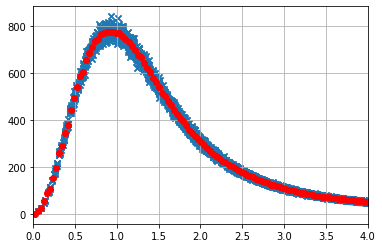

In [12]:
scatter_data = np.array(scatter_data)

bin_means, bin_edges, binnumber = binned_statistic(scatter_data[:, 0], scatter_data[:, 1], bins=400, statistic='mean')
bin_means = np.nan_to_num(bin_means)
k = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.scatter(scatter_data[:, 0], scatter_data[:, 1], marker='x')
plt.xlim([0, 4])
plt.grid()
plt.plot(k, bin_means, 'ro')

i_max = np.argmax(bin_means)
Qs = k[i_max]
print(Qs)